<a href="https://colab.research.google.com/github/mikulicmateo/StockPrediction/blob/main/MultioutputModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import numpy as np
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from matplotlib import pyplot
from datetime import datetime
import tensorflow as tf

In [154]:

def calculate_typical_price(row):
    typical_price = (row[1] + row[2] + row[3])/3
    return typical_price

In [155]:
with open("/content/drive/MyDrive/dataset-extendedv3.json") as json_file:
    dataset = json.loads(json_file.read())

In [156]:
num_given_days = 60
num_predicted_days = 30
data_per_day = 8

seq_len_x = num_given_days * data_per_day
seq_stride_x = data_per_day
seq_len_y = num_predicted_days
seq_stride_y = 1

In [157]:
def make_y(data):
  new_data = []
  for i in range(len(data)):
    if i % data_per_day != 0:
      continue
    new_data.append(calculate_typical_price(data[i:i+data_per_day]))
  return new_data

In [158]:
def normalize(val, min_val, max_val):
  return (val - min_val) / (max_val - min_val)

In [159]:
def normalize_vals(arr):
  
  arr[0]= normalize(arr[0], open_minmax[0], open_minmax[1])
  arr[1]= normalize(arr[1], high_minmax[0], high_minmax[1])
  arr[2]= normalize(arr[2], low_minmax[0], low_minmax[1])
  arr[3]= normalize(arr[3], close_minmax[0], close_minmax[1])
  arr[4]= normalize(arr[4], volume_minmax[0], volume_minmax[1])
  arr[5]= normalize(arr[5], rsi_minmax[0], rsi_minmax[1])
  arr[6]= normalize(arr[6], sma_minmax[0], sma_minmax[1])
  arr[7]= normalize(arr[7], ema_minmax[0], ema_minmax[1])

  return arr

In [160]:
def update_minmax(curr_vals, update_val):
  if len(curr_vals) == 0:
    curr_vals = [update_val, update_val]
  if update_val < curr_vals[0]:
    curr_vals[0] = update_val
  elif update_val > curr_vals[1]:
    curr_vals[1] = update_val
  return curr_vals

In [161]:
open_minmax = []
high_minmax = []
low_minmax = []
close_minmax = []
volume_minmax = []
rsi_minmax = []
sma_minmax = []
ema_minmax = []

def update_minmax_vals(open, high, low, close, volume, rsi, sma, ema):
  global open_minmax 
  global high_minmax 
  global low_minmax 
  global close_minmax
  global volume_minmax
  global rsi_minmax 
  global sma_minmax 
  global ema_minmax
  
  open_minmax = update_minmax(open_minmax, open)
  high_minmax = update_minmax(high_minmax, high)
  low_minmax = update_minmax(low_minmax, low)
  close_minmax = update_minmax(close_minmax, close)
  volume_minmax = update_minmax(volume_minmax, volume)
  rsi_minmax = update_minmax(rsi_minmax, rsi)
  sma_minmax = update_minmax(sma_minmax, sma)
  ema_minmax = update_minmax(ema_minmax, ema)


In [162]:
def initialize_normalization_vals(dataset):
  for j in dataset.keys():
    for i in dataset[j]:
      date_string = i.get('date')
      if date_string < "2018-01-01":
          update_minmax_vals(float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema')))

In [163]:
def normalize_x_dataset(x_dataset):
  new_x_dataset = []
  for i in range(len(x_dataset)):
    if i % data_per_day != 0:
      continue
    new_x_dataset = new_x_dataset + normalize_vals(x_dataset[i:i+data_per_day])
  return new_x_dataset

In [164]:
ds_train_x = None
ds_train_y = None

ds_valid_x = None
ds_valid_y = None

ds_test_x = None
ds_test_y = None

def load_from_d(dataset):
  global ds_train_x
  global ds_train_y
  global ds_valid_x
  global ds_valid_y
  global ds_test_x   
  global ds_test_y
  initialize_normalization_vals(dataset)
  for j in dataset.keys():
    data_train = []
    data_valid = []
    data_test = []
    for i in dataset[j]:
      date_string = i.get('date')
      if date_string < "2018-01-01":
          data_train = data_train + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])
          
      elif date_string < "2020-01-01":
          data_valid = data_valid + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])
      else:
          data_test = data_test + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])
          
    if len(data_train) >= seq_len_x:
      
      target_train = make_y(data_train)

      data_train = normalize_x_dataset(data_train)

      x_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_train,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_train)-(data_per_day * num_predicted_days)
      )

      y_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_train,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if len(data_valid) >= seq_len_x:

      target_valid = make_y(data_valid)

      data_valid = normalize_x_dataset(data_valid)

      x_valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_valid,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_valid)-(data_per_day * num_predicted_days)
      )

      y_valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_valid,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if len(data_test) >= seq_len_x:

      target_test = make_y(data_test)

      data_test = normalize_x_dataset(data_test)

      x_test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_test,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_test)-(data_per_day * num_predicted_days)
      )

      y_test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_test,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if not ds_train_x:
      ds_train_x = x_train_dataset
      ds_train_y = y_train_dataset
      ds_valid_x = x_valid_dataset
      ds_valid_y = y_valid_dataset
      ds_test_x = x_test_dataset
      ds_test_y = y_test_dataset
    else:
      ds_train_x = ds_train_x.concatenate(x_train_dataset)
      ds_train_y = ds_train_y.concatenate(y_train_dataset)
      ds_valid_x = ds_valid_x.concatenate(x_valid_dataset)
      ds_valid_y = ds_valid_y.concatenate(y_valid_dataset)
      ds_test_x = ds_test_x.concatenate(x_test_dataset)
      ds_test_y = ds_test_y.concatenate(y_test_dataset)

In [165]:
load_from_d(dataset)

In [166]:
def create_model():
  l_model = Sequential()
  l_model.add(Input(480))
#  l_model.add(Dense(960, activation="relu"))
#  l_model.add(Dense(480, activation="softplus"))
  l_model.add(Dense(240, activation="relu"))
  l_model.add(Dense(120, activation="softplus"))
#  l_model.add(Dropout(0.5))
  l_model.add(Dense(60, activation="linear"))
  l_model.add(Dense(30, activation="softplus"))
  l_model.compile(Adam(learning_rate=0.001), loss="msle", metrics=["mse", "mae", "msle"])
  return l_model

In [167]:
ds_train = tf.data.Dataset.zip((ds_train_x , ds_train_y)).batch(32)

In [168]:
ds_valid = tf.data.Dataset.zip((ds_valid_x, ds_valid_y)).batch(32)

In [169]:
for x,y in ds_valid:
  print(x.shape)
  print(y.shape)
  break
 

(32, 480)
(32, 30)


In [170]:
for x,y in ds_train:
  print(x.shape)
  print(y.shape)
  break

(32, 480)
(32, 30)


In [171]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000001)

In [172]:
model = create_model()
model.summary()
history = model.fit(ds_train, validation_data=ds_valid, epochs=50, verbose=1, shuffle=True, callbacks=[learning_rate_reduction])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 240)               115440    
                                                                 
 dense_27 (Dense)            (None, 120)               28920     
                                                                 
 dense_28 (Dense)            (None, 60)                7260      
                                                                 
 dense_29 (Dense)            (None, 30)                1830      
                                                                 
Total params: 153,450
Trainable params: 153,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
14499/14499 [==============================] - 137s 9ms/step - loss: 0.0752 - mse: 304.6522 - mae: 5.5230 - msle: 0.0752 - val_loss: 0.1222 - val_mse: 5694.7314 - val_ma

In [173]:
results = model.evaluate(ds_valid)
print(results)

1626/1626 [==============================] - 23s 9ms/step - loss: 0.0125 - mse: 109.1610 - mae: 3.0550 - msle: 0.0125
[0.012549618259072304, 109.16096496582031, 3.055008888244629, 0.012549618259072304]


In [174]:
ds_test_xx = ds_test_x.batch(32)
for x in ds_test_xx:
  print(x.shape)
  break

(32, 480)


In [175]:
predictions = model.predict(ds_test_xx)
print(predictions)

[[140.36728  140.3607   140.1052   ... 141.20003  141.21352  141.30798 ]
 [140.28128  140.2838   140.0409   ... 141.17749  141.18579  141.27803 ]
 [140.4877   140.48735  140.24747  ... 141.28108  141.282    141.3697  ]
 ...
 [ 48.794514  48.81765   48.815243 ...  49.77013   49.858574  49.843616]
 [ 48.524666  48.570324  48.591705 ...  49.812702  49.905453  49.89125 ]
 [ 48.383137  48.447292  48.489075 ...  49.949596  50.04972   50.03411 ]]


In [176]:
ds_test_yy = ds_test_y.batch(32)

# Predictions on test data

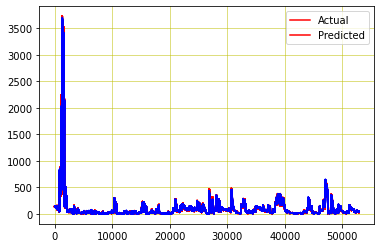

In [177]:
pyplot.plot(list(ds_test_y), linestyle='solid', color='r')
pyplot.plot(predictions, linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

In [178]:
print(len(list(ds_test_y)))
print(len(predictions))

52914
52914


## Actual

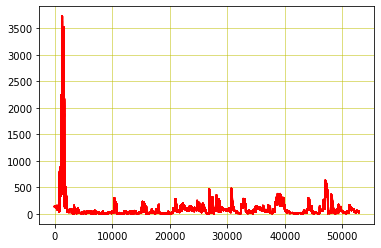

In [185]:
pyplot.plot(list(ds_test_y), linestyle='solid', color='r')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

## Predicted

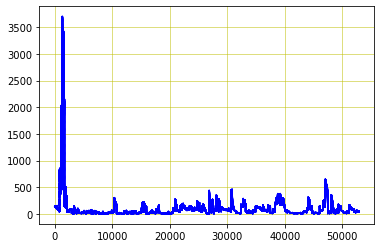

In [186]:
pyplot.plot(predictions, linestyle='dashed', color='b')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

# Predictions on train data

In [183]:
predictions_train = model.predict(ds_train_x.batch(32))

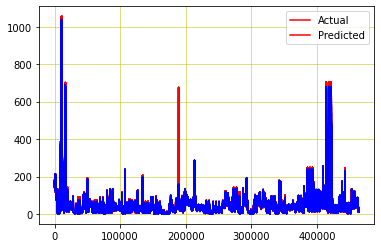

In [184]:
pyplot.plot(list(ds_train_y), linestyle='solid', color='r')
pyplot.plot(predictions_train, linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

## Actual

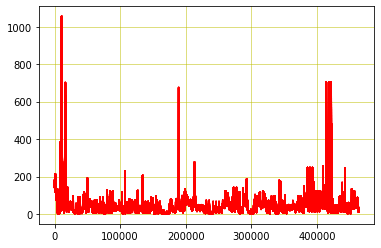

In [187]:
pyplot.plot(list(ds_train_y), linestyle='solid', color='r')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

## Predicted

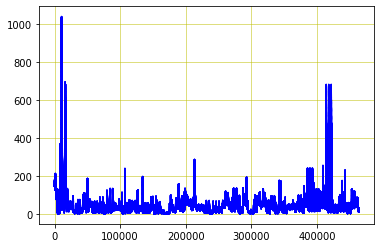

In [188]:
pyplot.plot(predictions_train, linestyle='dashed', color='b')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

# AMD prediction

In [189]:
with open("/content/drive/MyDrive/dataset-amd.json") as json_file:
    amd_dataset = json.loads(json_file.read())

In [195]:
ds_train_x = None
ds_train_y = None
ds_valid_x = None
ds_valid_y = None
ds_test_x = None
ds_test_y = None
load_from_d(amd_dataset)

In [196]:
predictions_amd = model.predict(ds_test_x.batch(32))

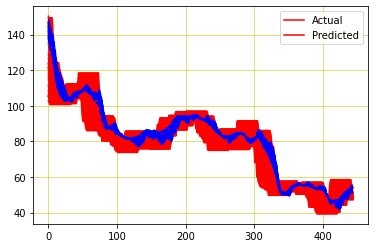

In [197]:
pyplot.plot(list(ds_test_y), linestyle='solid', color='r')
pyplot.plot(predictions_amd, linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

In [198]:
print(len(list(ds_test_y)))
print(len(predictions_amd))

445
445


# Testing timeseries_dataset functions

In [179]:
test_functions_dataset = []
ds_train_x_testing = None
ds_train_y_testing = None

def test_dataset_making(testing_dataset):

   global ds_train_x_testing
   global ds_train_y_testing
   print(len(testing_dataset))
   if len(testing_dataset) >= seq_len_x:
     
     target_train = make_y(testing_dataset)

     x_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
         testing_dataset,
         None,
         sequence_length=seq_len_x,
         sequence_stride=seq_stride_x,
         sampling_rate=1,
         batch_size=None,
         end_index=len(testing_dataset)-(data_per_day * num_predicted_days)
     )

     y_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
         target_train,
         None,
         sequence_length=seq_len_y,
         sequence_stride=seq_stride_y,
         sampling_rate=1,
         batch_size=None,
         start_index=num_given_days,
     )

   if not ds_train_x_testing:
     ds_train_x_testing = x_train_dataset
     ds_train_y_testing = y_train_dataset
   else:
     ds_train_x_testing = ds_train_x_testing.concatenate(x_train_dataset)
     ds_train_y_testing = ds_train_y_testing.concatenate(y_train_dataset)

In [180]:
for i in range(900):
  test_functions_dataset = test_functions_dataset + [1, 2, 1, 1, 1000, 50, 50, 50]

test_dataset_making(test_functions_dataset)

7200


In [181]:
ds_testing = tf.data.Dataset.zip((ds_train_x_testing,ds_train_y_testing)).batch(1)

In [182]:
for x,y in ds_testing:
  print(x)
  print(y)
  print("_____________________________________________")

Streaming output truncated to the last 5000 lines.
  1000   50   50   50    1    2    1    1 1000   50   50   50    1    2
     1    1 1000   50   50   50    1    2    1    1 1000   50   50   50
     1    2    1    1 1000   50   50   50    1    2    1    1 1000   50
    50   50    1    2    1    1 1000   50   50   50    1    2    1    1
  1000   50   50   50]], shape=(1, 480), dtype=int32)
tf.Tensor(
[[1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334]], shape=(1, 30), dtype=float32)
_____________________________________________
tf.Tensor(
[[   1    2    1    1 1000   50   50   50    1    2    1    1 1000   50
    50   50    1    2    1    1 1000   50   50   50    1    2    1    1
  1000   50   50   50    1    2    1    1 1000   50 